# 概念
线程是jvm调度的最小单元，也叫做轻量级进程，进程是由线程组成，线程拥有私有的程序技术器以及栈，并且能够访问堆中的共享资源。这里提出一个问题，为什么要用多线程？有一下几点，首先，随着cpu核心数的增加，计算机硬件的并行计算能力得到提升，而同一个时刻一个线程只能运行在一个cpu上，那么计算机的资源被浪费了，所以需要使用多线程。其次，也是为了提高系统的响应速度，如果系统只有一个线程可以执行，那么当不同用户有不同的请求时，由于上一个请求没处理完，那么其他的用户必定需要在一个队列中等待，大大降低响应速度，所以需要多线程。这里继续介绍多线程的几种状态：
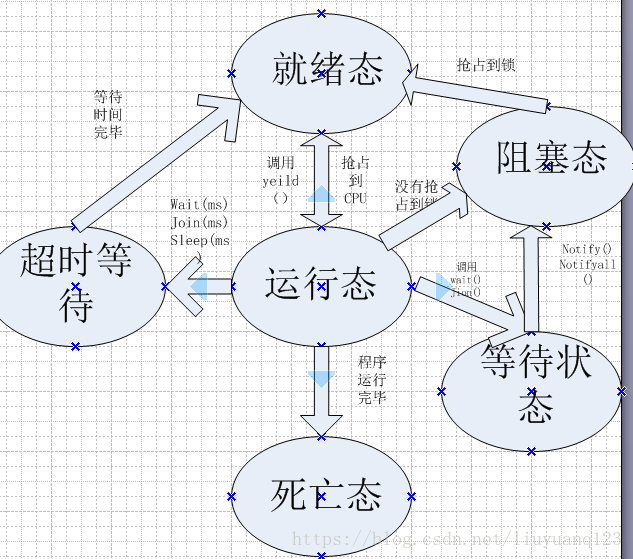

这里可以看到多线程有六种状态，分别是就绪态，运行态，死亡态，阻塞态，等待态，和超时等待态，各种状态之间的切换如上图所示。这里的状态切换是通过synchronized锁下的方法实现，对应的Lock锁下的方法同样可以实现这些切换。

# 线程的创建
线程的创建有两种方式，第一种是**继承Thread类**，第二种是**实现Runnable接口**。

第一种代码：

In [13]:
class MyThread extends Thread{
	int j=20;
	public void run(){
		for (int i = 0; i < 20; i++) {
			try {
				Thread.sleep(100);  //休眠1min
			} catch (InterruptedException e) {
				// TODO Auto-generated catch block
				e.printStackTrace();
			}
			System.out.println(this.getName()+",i="+j--);//getName(): 该方法继承自Thread类
		}
	}
}

In [14]:
MyThread mythread = new MyThread();
mythread.run();

Thread-4,i=20
Thread-4,i=19
Thread-4,i=18
Thread-4,i=17
Thread-4,i=16
Thread-4,i=15
Thread-4,i=14
Thread-4,i=13
Thread-4,i=12
Thread-4,i=11
Thread-4,i=10
Thread-4,i=9
Thread-4,i=8
Thread-4,i=7
Thread-4,i=6
Thread-4,i=5
Thread-4,i=4
Thread-4,i=3
Thread-4,i=2
Thread-4,i=1


第二种方法：

In [17]:
class MyRunnable implements Runnable{
	int j=20;
	@Override//重写run方法
	public void run() {
		for (int i = 0; i < 20; i++) {
			System.out.println(Thread.currentThread().getName()+",j="+this.j--);
		}
	}
	
}

In [33]:
MyRunnable myRunnable = new MyRunnable();
Thread t1 = new Thread(myRunnable);
Thread t2 = new Thread(myRunnable);
t1.start();
t2.start();

-500
-501
-502
-503
-504
-505
-506
-507
-508
-509
-510
-511
-512
-513
-514
-515
-516
-517
-518
-519
-520
-521
-522
-523
-524
-525
-526
-527
-528
-529
-530
-531
-532
-533
-534
-535
-536
-537
-538
-539
-540
-541
-542
-543
-544
-545
-546
-547
-548
-549
-550
-551
-552
-553
-554
-555
-556
-557
-558
-559
-560
-561
-562
-563
-564
-565
-566
-567
-568
-569
-570
-571
-572
-573
-574
-575
-576
-577
-578
-579
-580
-581
-582
-583
-584
-585
-586
-587
-588
-589
-590
-591
-592
-593
-594
-595
-596
-597
-598
-599
-600
-601
-602
-603
-604
-605
-606
-607
-608
-609
-610
-611
-612
-613
-614
-615
-616
-617
-618
-619
-620
-621
-622
-623
-624
-625
-626
-627
-628
-629
-630
-631
-632
-633
-634
-635
-636
-637
-638
-639
-640
-641
-642
-643
-644
-645
-646
-647
-648
-649
-650
-651
-652
-653
-654
-655
-656
-657
-658
-659
-660
-661
-662
-663
-664
-665
-666
-667
-668
-669
-670
-671
-672
-673
-674
-675
-676
-677
-678
-679
-680
-681
-682
-683
-684
-685
-686
-687
-688
-689
-690
-691
-692
-693
-694
-695
-696
-697
-698
-699


这就是两种创建线程的方法，在这两种方法中第二种方法时一般情况下的用法，因为继承只能继承一个类，但是可以实现多个接口，这样拓展性更好。

# 线程安全测试
线程安全是多线程编程中经常需要考虑的一个问题，*线程安全是指多线程环境下多个线程可能会同时对同一段代码或者共享变量进行执行*，**如果每次运行的结果和单线程下的结果是一致的，那么就是线程安全的，如果每次运行的结果不一致，那么就是线程不安全的**。这里对线程安全做一个测试：

In [36]:
class MyRunnable implements Runnable{
	static int j=1000;
	@Override
	public void run() {
		for (int i = 0; i < 500; i++) {
			System.out.println(j--);
		}
	}
	
}

In [37]:
MyRunnable myRunnable = new MyRunnable();
Thread t1 = new Thread(myRunnable);
Thread t2 = new Thread(myRunnable);
t1.start();
t2.start();

1000
999
998
997
996
995
994
993
992
991
990
989
988
987
986
985
984
983
982
981
980
979
978
977
976
975
974
973
972
971
970
969
968
967
966
965
964
963
962
961
960
959
958
957
956
955
954
953
952
951
950
949
948
947
946
945
944
943
942
941
940
939
938
937
936
935
934
933
932
931
930
929
928
927
926
925
924
923
922
921
920
919
918
917
916
915
914
913
912
911
910
909
908
907
906
905
904
903
902
901
900
899
898
897
896
895
894
893
892
891
890
889
888
887
886
885
884
883
882
881
880
879
878
877
876
875
874
873
872
871
870
869
868
867
866
865
864
863
862
861
860
859
858
857
856
855
854
853
852
851
850
849
848
847
846
845
844
843
842
841
840
839
838
837
836
835
834
833
832
831
830
829
828
827
826
825
824
823
822
821
820
819
818
817
816
815
814
813
812
811
810
809
808
807
806
805
804
803
802
801
800
799
798
797
796
795
794
793
792
791
790
789
788
787
786
785
784
783
782
781
780
779
778
777
776
775
774
773
772
771
770
769
768
767
766
765
764
763
762
761
760
759
758
757
756
755
754
753
752
751

可以看到，这里同时两个线程同时对共享变量j进行访问，并且减1。

并且多次执行程序的结果还不一致，这就是线程不安全的情况，通过加锁可以保证线程安全。

# 锁
java中有两种锁，一种是**重量级锁synchronized**，*jdk1.6经过锁优化加入了偏向锁和轻量级锁*，另一种是JUC并发包下的Lock锁，synchronized锁也称对象锁，每个对象都有一个对象锁。这里通过加锁的方式实现线程安全：

代码：

In [34]:
class MyRunnable implements Runnable{
	static int j=1000;
	@Override
	public synchronized void run() {
		for (int i = 0; i < 500; i++) {
			System.out.println(j--);
		}
	}
}

In [35]:
MyRunnable myRunnable = new MyRunnable();
Thread t1 = new Thread(myRunnable);
Thread t2 = new Thread(myRunnable);
t1.start();
t2.start();

1000
999
998
997
996
995
994
993
992
991
990
989
988
987
986
985
984
983
982
981
980
979
978
977
976
975
974
973
972
971
970
969
968
967
966
965
964
963
962
961
960
959
958
957
956
955
954
953
952
951
950
949
948
947
946
945
944
943
942
941
940
939
938
937
936
935
934
933
932
931
930
929
928
927
926
925
924
923
922
921
920
919
918
917
916
915
914
913
912
911
910
909
908
907
906
905
904
903
902
901
900
899
898
897
896
895
894
893
892
891
890
889
888
887
886
885
884
883
882
881
880
879
878
877
876
875
874
873
872
871
870
869
868
867
866
865
864
863
862
861
860
859
858
857
856
855
854
853
852
851
850
849
848
847
846
845
844
843
842
841
840
839
838
837
836
835
834
833
832
831
830
829
828
827
826
825
824
823
822
821
820
819
818
817
816
815
814
813
812
811
810
809
808
807
806
805
804
803
802
801
800
799
798
797
796
795
794
793
792
791
790
789
788
787
786
785
784
783
782
781
780
779
778
777
776
775
774
773
772
771
770
769
768
767
766
765
764
763
762
761
760
759
758
757
756
755
754
753
752
751

main中创建两个线程，测试多次的结果都是一样的：

说明实现的线程安全，因为当加锁过后，每次只能有一个线程访问被加锁的代码，这样就不会出现线程安全了。

# sleep
sleep是让当前线程睡眠，睡眠一段时间后重新获取到cpu的使用权。

代码如下：

In [ ]:
try {
    Thread.sleep(100);
} catch (InterruptedException e) {
    // TODO Auto-generated catch block
    e.printStackTrace();
}

这里表示线程会睡眠100ms后再次到就绪状态中，**这里为什么sleep是Thread的类方法而不是线程的方法，因为，能调用sleep的线程肯定是运行着的，而其他线程也是未运行的，所以调用其他线程的sleep是没有意义的**。